I have downloaded a dataset from kaggle that focuses on health insurance claims. 
This dataset focuses on provider fraud within Medicare. The dataset can be found on <https://www.kaggle.com/rohitrox/healthcare-provider-fraud-detection-analysis?select=Train_Outpatientdata-1542865627584.csv>

The object of this validation project is to predict fraudulent claims. 

Healthcare fraud doesn't just happen with it's policy holders but it also exists with medical practices. It ranges from: 
-billing for services that wrre not provided, misrepresenting the service provided, duplicated submissions for the same service, up charging for a more expensive service that was not actually provided and billing an insurance company for something that is covered in order to cover the costs of something the claiment does not have coverage for. 
    

My data file holds separate csvs' that contain separate train and test files. These are split up into beneficiary and outpatient data. 
I will explore and give a glimpse at each file, conduct exploratory data analysis and identify the biggest factors in fradulent detection


# Data Cleaning & Understanding

In [1]:
conda install -c conda-forge pandas-profiling



CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://conda.anaconda.org/conda-forge/osx-64/current_repodata.json>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.
'https://conda.anaconda.org/conda-forge/osx-64'



Note: you may need to restart the kernel to use updated packages.


In [2]:
#import all the necessary libraries and tools
import numpy as np

import pandas as pd
import pandas_profiling as profile #this is to check the correlation and data distribution

import scipy as sc
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

import warnings #this is to omit all warning notifications due to large files
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import pickle

import tensorflow as tf

from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 2

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Labels = ['Normal', 'Fraud']

Using TensorFlow backend.


In [3]:
#let's take a look at the datasets

train = pd.read_csv('/Users/aqureshi/Desktop/DS 021720/axa_validation_project/insuranceclaims/data/Train-1542865627584.csv')
train_outpatient = pd.read_csv('/Users/aqureshi/Desktop/DS 021720/axa_validation_project/insuranceclaims/data/Train_Outpatientdata-1542865627584.csv')
train_inpatient = pd.read_csv('/Users/aqureshi/Desktop/DS 021720/axa_validation_project/insuranceclaims/data/Train_Inpatientdata-1542865627584.csv')
train_beneficiary = pd.read_csv('/Users/aqureshi/Desktop/DS 021720/axa_validation_project/insuranceclaims/data/Train_Beneficiarydata-1542865627584.csv')

test = pd.read_csv('/Users/aqureshi/Desktop/DS 021720/axa_validation_project/insuranceclaims/data/Test-1542969243754.csv')
test_beneficiary = pd.read_csv('/Users/aqureshi/Desktop/DS 021720/axa_validation_project/insuranceclaims/data/Test_Beneficiarydata-1542969243754.csv')
test_inpatient = pd.read_csv('/Users/aqureshi/Desktop/DS 021720/axa_validation_project/insuranceclaims/data/Test_Inpatientdata-1542969243754.csv')
test_outpatient = pd.read_csv('/Users/aqureshi/Desktop/DS 021720/axa_validation_project/insuranceclaims/data/Test_Outpatientdata-1542969243754.csv')

In [4]:
train_outpatient.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [5]:
train_outpatient.shape

(517737, 27)

In [6]:
train_inpatient.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [7]:
train_inpatient.shape

(40474, 30)

In [8]:
train_beneficiary.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,1,2,2,2,2,0,0,1790,1200


In [9]:
test_beneficiary.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11007,1940-09-01,2009-12-01,1,2,0,45,610,12,12,...,2,1,2,1,1,2,0,0,1490,160
2,BENE11010,1936-07-01,NaN,2,1,0,41,30,12,12,...,2,1,1,1,2,2,0,0,1170,660
3,BENE11011,1914-03-01,NaN,2,2,0,1,360,12,12,...,1,1,2,2,1,1,5000,1068,250,320
4,BENE11014,1938-04-01,NaN,2,1,Y,45,780,12,12,...,1,2,1,2,2,2,21260,2136,120,100


The beneficiary data seems to be more informative of specific diseases, disorders and severity of each claimant. This is either a 1 or 2. We should change this to a 0 for negative and 1 for positive. 

In [10]:
train_beneficiary = train_beneficiary.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease':2, 'ChronicCond_Cancer':2, 'ChronicCond_ObstrPulmonary':2, 'ChronicCond_Depression':2, 'ChronicCond_Diabetes':2, 'ChronicCond_IschemicHeart':2, 'ChronicCond_Osteoporasis':2, 'ChronicCond_rheumatoidarthritis':2, 'ChronicCond_stroke':2}, 0)
train_beneficiary = train_beneficiary.replace({'RenalDiseaseIndicator':'Y'}, 1)
test_beneficiary = test_beneficiary.replace({'RenalDiseaseIndicator':'Y'}, 1)
test_beneficiary = test_beneficiary.replace({'ChronicCond_Alzheimer':2, 'ChronicCond_Heartfailure':2, 'ChronicCond_KidneyDisease':2, 'ChronicCond_Cancer':2, 'ChronicCond_ObstrPulmonary':2, 'ChronicCond_Depression':2, 'ChronicCond_Diabetes':2, 'ChronicCond_IschemicHeart':2, 'ChronicCond_Osteoporasis':2, 'ChronicCond_rheumatoidarthritis':2, 'ChronicCond_stroke':2}, 0)
test_beneficiary = test_beneficiary.replace({'RenalDiseaseIndicator':'Y'}, 1)

In [11]:
#let's make sure this has been changed
test_beneficiary.head(1)
train_beneficiary.head(1)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,0,1,1,36000,3204,60,70


In [12]:
train_beneficiary.shape

(138556, 25)

In [13]:
#let's check the data types for the train sets. 
print("Train Inpatient Data Types:", train_inpatient.dtypes)
print("Train Outpaitet Data Types:", train_outpatient.dtypes)
print("Train bBeneficiary Data Types:", train_beneficiary.dtypes)

Train Inpatient Data Types: BeneID                     object
ClaimID                    object
ClaimStartDt               object
ClaimEndDt                 object
Provider                   object
InscClaimAmtReimbursed      int64
AttendingPhysician         object
OperatingPhysician         object
OtherPhysician             object
AdmissionDt                object
ClmAdmitDiagnosisCode      object
DeductibleAmtPaid         float64
DischargeDt                object
DiagnosisGroupCode         object
ClmDiagnosisCode_1         object
ClmDiagnosisCode_2         object
ClmDiagnosisCode_3         object
ClmDiagnosisCode_4         object
ClmDiagnosisCode_5         object
ClmDiagnosisCode_6         object
ClmDiagnosisCode_7         object
ClmDiagnosisCode_8         object
ClmDiagnosisCode_9         object
ClmDiagnosisCode_10        object
ClmProcedureCode_1        float64
ClmProcedureCode_2        float64
ClmProcedureCode_3        float64
ClmProcedureCode_4        float64
ClmProcedureCode_5  

## Feature Engineering
I would like to format the Date of Death and Date of Birth to say the age and not just the date

In [14]:
#let's create an age column 
train_beneficiary['DOB'] = pd.to_datetime(train_beneficiary['DOB'], format = '%Y-%m-%d')
train_beneficiary['DOD'] = pd.to_datetime(train_beneficiary['DOD'], format = '%Y-%m-%d', errors='ignore')
train_beneficiary['Age'] = round(((train_beneficiary['DOD'] - train_beneficiary['DOB']).dt.days)/365)

test_beneficiary['DOB'] = pd.to_datetime(test_beneficiary['DOB'], format = '%Y-%m-%d')
test_beneficiary['DOD'] = pd.to_datetime(test_beneficiary['DOD'], format = '%Y-%m-%d', errors='ignore')
test_beneficiary['Age'] = round(((test_beneficiary['DOD'] - test_beneficiary['DOB']).dt.days)/365)

In [15]:
#It seems that the last date of death recorded was in 2009. This means that this dataset is not that recent. Let's calculate the age for those who died in 09.
train_beneficiary.Age.fillna(round(((pd.to_datetime('2009-12-01', format = '%Y-%m-%d') - train_beneficiary['DOB']).dt.days)/365), inplace=True)

test_beneficiary.Age.fillna(round(((pd.to_datetime('2009-12-01', format = '%Y-%m-%d') - test_beneficiary['DOB']).dt.days)/365), inplace=True)

In [16]:
train_beneficiary.head(2)
test_beneficiary.head(2)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age
0,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,...,1,1,0,1,1,36000,3204,60,70,67.0
1,BENE11007,1940-09-01,2009-12-01,1,2,0,45,610,12,12,...,1,0,1,1,0,0,0,1490,160,69.0


In [17]:
#let's add another column that shows whether a claimant is dead or alive
train_beneficiary.loc[train_beneficiary.DOD.isna(), 'IsDead']=0
train_beneficiary.loc[train_beneficiary.DOD.notna(), 'IsDead']=1
train_beneficiary.loc[:,'IsDead'].head(7)

test_beneficiary.loc[test_beneficiary.DOD.isna(),'IsDead']=0
test_beneficiary.loc[test_beneficiary.DOD.notna(), 'IsDead']=1
test_beneficiary.loc[:, 'IsDead'].head(7)

0    0.0
1    1.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
Name: IsDead, dtype: float64

## Inpatient Data


In [18]:
train_inpatient.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [19]:
test_inpatient.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11014,CLM67387,2009-09-09,2009-09-16,PRV57070,9000,PHY317786,PHY427017,NaN,2009-09-09,...,5990,570,41071,4280,4443.0,5849.0,NaN,NaN,NaN,NaN
1,BENE11017,CLM31237,2008-12-25,2009-01-08,PRV54750,14000,PHY314656,PHY426644,NaN,2008-12-25,...,4549,29570,34831,NaN,5551.0,NaN,NaN,NaN,NaN,NaN
2,BENE11026,CLM78930,2009-12-09,2009-12-13,PRV53758,2000,PHY349495,NaN,NaN,2009-12-09,...,78650,7813,4254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11031,CLM56810,2009-06-23,2009-07-06,PRV55825,16000,PHY429538,PHY371893,NaN,2009-06-23,...,4254,41400,5849,41401,8152.0,3320.0,NaN,NaN,NaN,NaN
4,BENE11085,CLM34625,2009-01-20,2009-01-31,PRV52338,19000,PHY397161,NaN,NaN,2009-01-20,...,V6109,7242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
train_inpatient.isna().sum()
test_inpatient.isna().sum()

BeneID                       0
ClaimID                      0
ClaimStartDt                 0
ClaimEndDt                   0
Provider                     0
InscClaimAmtReimbursed       0
AttendingPhysician          31
OperatingPhysician        3962
OtherPhysician            8538
AdmissionDt                  0
ClmAdmitDiagnosisCode        0
DeductibleAmtPaid          196
DischargeDt                  0
DiagnosisGroupCode           0
ClmDiagnosisCode_1           0
ClmDiagnosisCode_2          54
ClmDiagnosisCode_3         169
ClmDiagnosisCode_4         404
ClmDiagnosisCode_5         719
ClmDiagnosisCode_6        1197
ClmDiagnosisCode_7        1736
ClmDiagnosisCode_8        2360
ClmDiagnosisCode_9        3238
ClmDiagnosisCode_10       8664
ClmProcedureCode_1        4118
ClmProcedureCode_2        8297
ClmProcedureCode_3        9328
ClmProcedureCode_4        9522
ClmProcedureCode_5        9549
ClmProcedureCode_6        9551
dtype: int64

There are a lot of null values within the dataset

## Feature Engineering 
add a column to show the number of days a claimant was admitted in hospital


In [21]:
#For inpatients the minimum stay is 1 day. We will adjust the inpatient data to say at least one day of admission
train_inpatient['AdmissionDt'] = pd.to_datetime(train_inpatient['AdmissionDt'], format = '%Y-%m-%d')
train_inpatient['DischargeDt'] = pd.to_datetime(train_inpatient['DischargeDt'], format ='%Y-%m-%d')
train_inpatient['DaysAdmitted'] = ((train_inpatient['DischargeDt'] - train_inpatient['AdmissionDt']).dt.days)+1

test_inpatient['AdmissionDt'] = pd.to_datetime(test_inpatient['AdmissionDt'], format = '%Y-%m-%d')
test_inpatient['DischargeDt'] = pd.to_datetime(test_inpatient['DischargeDt'], format = '%Y-%m-%d')
test_inpatient['DaysAdmitted'] =((test_inpatient['DischargeDt'] - test_inpatient['AdmissionDt']).dt.days)+1

In [22]:
#let's have a look at tthe most time spent admitted and the least time spent
print(' Minimum days admitted train:-', train_inpatient.DaysAdmitted.min())
print('Maxmium days admitted train:-', train_inpatient.DaysAdmitted.max())
train_inpatient.DaysAdmitted.isnull().sum() #checking null values

print('Minimum days admitted test:-', test_inpatient.DaysAdmitted.min())
print('Maximum days admitted test:-', test_inpatient.DaysAdmitted.max())
test_inpatient.DaysAdmitted.isnull().sum() #checking null values

 Minimum days admitted train:- 1
Maxmium days admitted train:- 36
Minimum days admitted test:- 1
Maximum days admitted test:- 36


0

# Outpatient Data Understanding


In [23]:
#chekcing total null values
train_outpatient.isna().sum()
test_outpatient.isna().sum()

BeneID                         0
ClaimID                        0
ClaimStartDt                   0
ClaimEndDt                     0
Provider                       0
InscClaimAmtReimbursed         0
AttendingPhysician           316
OperatingPhysician        104237
OtherPhysician             78222
ClmDiagnosisCode_1          2578
ClmDiagnosisCode_2         47731
ClmDiagnosisCode_3         76575
ClmDiagnosisCode_4         95371
ClmDiagnosisCode_5        107875
ClmDiagnosisCode_6        114035
ClmDiagnosisCode_7        117871
ClmDiagnosisCode_8        120310
ClmDiagnosisCode_9        122278
ClmDiagnosisCode_10       125578
ClmProcedureCode_1        125807
ClmProcedureCode_2        125832
ClmProcedureCode_3        125839
ClmProcedureCode_4        125841
ClmProcedureCode_5        125841
ClmProcedureCode_6        125841
DeductibleAmtPaid              0
ClmAdmitDiagnosisCode     100036
dtype: int64

## Train and Data Exploration and Understanding

In [24]:
print('Shape of Train:', train.shape)
print('Shape of Train Beneficiary:', train_beneficiary.shape)
print('Shape of Train Inpatient:', train_inpatient.shape)
print('Shape of Train Outpatient:', train_outpatient.shape)

Shape of Train: (5410, 2)
Shape of Train Beneficiary: (138556, 27)
Shape of Train Inpatient: (40474, 31)
Shape of Train Outpatient: (517737, 27)


In [25]:
print('Shape of Test:', test.shape)
print('Shape of Test Beneficiary:', test_beneficiary.shape)
print('Shape of Test Inpatient:', test_inpatient.shape)
print('Shape of Test Outpatient:', test_outpatient.shape)

Shape of Test: (1353, 1)
Shape of Test Beneficiary: (63968, 27)
Shape of Test Inpatient: (9551, 31)
Shape of Test Outpatient: (125841, 27)


In [26]:
train_outpatient.columns #lets have a look at the columns to see what datasets we can merge

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
      dtype='object')

In [27]:
train_inpatient.columns


Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'DaysAdmitted'],
      dtype='object')

### Merge inpatient and outpaitent sets

In [28]:
train_inandout = pd.merge(train_outpatient, train_inpatient, left_on=['BeneID',
                                                                      'ClaimID', 
                                                                      'ClaimStartDt', 
                                                                      'Provider', 
                                                                      'InscClaimAmtReimbursed', 
                                                                      'AttendingPhysician', 
                                                                      'OperatingPhysician', 
                                                                      'OtherPhysician', 
                                                                      'ClmDiagnosisCode_1', 
                                                                      'ClmDiagnosisCode_2', 
                                                                      'ClmDiagnosisCode_3', 
                                                                      'ClmDiagnosisCode_4', 
                                                                      'ClmDiagnosisCode_5', 
                                                                      'ClmDiagnosisCode_6', 
                                                                      'ClmDiagnosisCode_7', 
                                                                      'ClmDiagnosisCode_8', 
                                                                      'ClmDiagnosisCode_9', 
                                                                      'ClmDiagnosisCode_10', 
                                                                      'ClmProcedureCode_1', 
                                                                      'ClmProcedureCode_2', 
                                                                      'ClmProcedureCode_3', 
                                                                      'ClmProcedureCode_4', 
                                                                      'ClmProcedureCode_5', 
                                                                      'ClmProcedureCode_6', 
                                                                      'DeductibleAmtPaid', 
                                                                      'ClmAdmitDiagnosisCode'], 
                          right_on=['BeneID',
                                    'ClaimID',
                                    'ClaimStartDt',
                                    'Provider',
                                    'InscClaimAmtReimbursed',
                                    'AttendingPhysician',
                                    'OperatingPhysician',
                                    'OtherPhysician',
                                    'ClmDiagnosisCode_1',
                                    'ClmDiagnosisCode_2',
                                    'ClmDiagnosisCode_3',
                                    'ClmDiagnosisCode_4',
                                    'ClmDiagnosisCode_5',
                                    'ClmDiagnosisCode_6',
                                    'ClmDiagnosisCode_7',
                                    'ClmDiagnosisCode_8',
                                    'ClmDiagnosisCode_9',
                                    'ClmDiagnosisCode_10',
                                    'ClmProcedureCode_1',
                                    'ClmProcedureCode_2',
                                    'ClmProcedureCode_3',
                                    'ClmProcedureCode_4',
                                    'ClmProcedureCode_5',
                                    'ClmProcedureCode_6',
                                    'DeductibleAmtPaid',
                                    'ClmAdmitDiagnosisCode'], 
                          how='outer')

test_inandout = pd.merge(test_outpatient, test_inpatient, left_on=['BeneID',
                                                                      'ClaimID', 
                                                                      'ClaimStartDt', 
                                                                      'Provider', 
                                                                      'InscClaimAmtReimbursed', 
                                                                      'AttendingPhysician', 
                                                                      'OperatingPhysician', 
                                                                      'OtherPhysician', 
                                                                      'ClmDiagnosisCode_1', 
                                                                      'ClmDiagnosisCode_2', 
                                                                      'ClmDiagnosisCode_3', 
                                                                      'ClmDiagnosisCode_4', 
                                                                      'ClmDiagnosisCode_5', 
                                                                      'ClmDiagnosisCode_6', 
                                                                      'ClmDiagnosisCode_7', 
                                                                      'ClmDiagnosisCode_8', 
                                                                      'ClmDiagnosisCode_9', 
                                                                      'ClmDiagnosisCode_10', 
                                                                      'ClmProcedureCode_1', 
                                                                      'ClmProcedureCode_2', 
                                                                      'ClmProcedureCode_3', 
                                                                      'ClmProcedureCode_4', 
                                                                      'ClmProcedureCode_5', 
                                                                      'ClmProcedureCode_6', 
                                                                      'DeductibleAmtPaid', 
                                                                      'ClmAdmitDiagnosisCode'], 
                          right_on=['BeneID',
                                    'ClaimID',
                                    'ClaimStartDt',
                                    'Provider',
                                    'InscClaimAmtReimbursed',
                                    'AttendingPhysician',
                                    'OperatingPhysician',
                                    'OtherPhysician',
                                    'ClmDiagnosisCode_1',
                                    'ClmDiagnosisCode_2',
                                    'ClmDiagnosisCode_3',
                                    'ClmDiagnosisCode_4',
                                    'ClmDiagnosisCode_5',
                                    'ClmDiagnosisCode_6',
                                    'ClmDiagnosisCode_7',
                                    'ClmDiagnosisCode_8',
                                    'ClmDiagnosisCode_9',
                                    'ClmDiagnosisCode_10',
                                    'ClmProcedureCode_1',
                                    'ClmProcedureCode_2',
                                    'ClmProcedureCode_3',
                                    'ClmProcedureCode_4',
                                    'ClmProcedureCode_5',
                                    'ClmProcedureCode_6',
                                    'DeductibleAmtPaid',
                                    'ClmAdmitDiagnosisCode'], 
                          how='outer')

In [29]:
print('Train_inandout', train_inandout.shape)
print('Test_inandout', test_inandout.shape)

Train_inandout (558211, 32)
Test_inandout (135392, 32)


In [30]:
train_inandout.head(5)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt_x,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,ClaimEndDt_y,AdmissionDt,DischargeDt,DiagnosisGroupCode,DaysAdmitted
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,0.0,56409,NaN,NaT,NaT,NaN,NaN
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,0.0,79380,NaN,NaT,NaT,NaN,NaN
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,0.0,NaN,NaN,NaT,NaT,NaN,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,0.0,NaN,NaN,NaT,NaT,NaN,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,0.0,71947,NaN,NaT,NaT,NaN,NaN


In [31]:
test_inandout.head(5)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt_x,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,ClaimEndDt_y,AdmissionDt,DischargeDt,DiagnosisGroupCode,DaysAdmitted
0,BENE11001,CLM392397,2009-06-02,2009-06-02,PRV55962,30,PHY347633,NaN,PHY347633,V5832,...,NaN,NaN,NaN,0.0,NaN,NaN,NaT,NaT,NaN,NaN
1,BENE11001,CLM430760,2009-06-23,2009-06-23,PRV56112,30,PHY381777,NaN,PHY381777,9594,...,NaN,NaN,NaN,0.0,NaN,NaN,NaT,NaT,NaN,NaN
2,BENE11007,CLM233081,2009-03-07,2009-03-07,PRV56979,200,PHY425311,NaN,PHY425311,7248,...,NaN,NaN,NaN,0.0,NaN,NaN,NaT,NaT,NaN,NaN
3,BENE11007,CLM496381,2009-07-29,2009-07-29,PRV56573,10,PHY393253,PHY347995,NaN,58889,...,NaN,NaN,NaN,0.0,5939,NaN,NaT,NaT,NaN,NaN
4,BENE11007,CLM521391,2009-08-12,2009-08-12,PRV56573,10,PHY417685,NaN,PHY382041,V666,...,NaN,NaN,NaN,0.0,NaN,NaN,NaT,NaT,NaN,NaN


### Merge beneficiary data

In [32]:
#there are columns in beneficiary that also match the data above. let's go ahead and merge this as well
train_merge_ben_inandout = pd.merge(train_inandout, train_beneficiary, left_on='BeneID', right_on='BeneID', how='inner')

test_merge_ben_inandout = pd.merge(test_inandout, test_beneficiary, left_on='BeneID', right_on='BeneID', how='inner')

In [33]:
#check the shape because it is expanding
print('Shape of All patient details within the train dataset:', train_merge_ben_inandout.shape)
print('Shape of all patient details within the test dataset:', test_merge_ben_inandout.shape)
train_merge_ben_inandout.head(2)

Shape of All patient details within the train dataset: (558211, 58)
Shape of all patient details within the test dataset: (135392, 58)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt_x,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,IsDead
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,0,0,0,0,0,0,30,50,73.0,0.0
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,1,0,0,0,0,0,90,40,73.0,0.0


In [34]:
#now lets merge the train csv itself with the above
train_all_data = pd.merge(train, train_merge_ben_inandout, on='Provider')
test_all_data = pd.merge(test, test_merge_ben_inandout, on='Provider')

In [35]:
#let's have a look at total missing values
train_all_data.isnull().sum()*100/len(train_all_data)


Provider                             0.000000
PotentialFraud                       0.000000
BeneID                               0.000000
ClaimID                              0.000000
ClaimStartDt                         0.000000
ClaimEndDt_x                         7.250663
InscClaimAmtReimbursed               0.000000
AttendingPhysician                   0.270149
OperatingPhysician                  79.497538
OtherPhysician                      64.218548
ClmDiagnosisCode_1                   1.872589
ClmDiagnosisCode_2                  35.041588
ClmDiagnosisCode_3                  56.458221
ClmDiagnosisCode_4                  70.524407
ClmDiagnosisCode_5                  79.949517
ClmDiagnosisCode_6                  84.881702
ClmDiagnosisCode_7                  88.144805
ClmDiagnosisCode_8                  90.425843
ClmDiagnosisCode_9                  92.509105
ClmDiagnosisCode_10                 99.102490
ClmProcedureCode_1                  95.824160
ClmProcedureCode_2                

In [36]:
#let's have a look at total missing values
test_all_data.isnull().sum()*100/len(test_all_data)

Provider                             0.000000
BeneID                               0.000000
ClaimID                              0.000000
ClaimStartDt                         0.000000
ClaimEndDt_x                         7.054331
InscClaimAmtReimbursed               0.000000
AttendingPhysician                   0.256293
OperatingPhysician                  79.915357
OtherPhysician                      64.080596
ClmDiagnosisCode_1                   1.904101
ClmDiagnosisCode_2                  35.293814
ClmDiagnosisCode_3                  56.682817
ClmDiagnosisCode_4                  70.739039
ClmDiagnosisCode_5                  80.207102
ClmDiagnosisCode_6                  85.109903
ClmDiagnosisCode_7                  88.341261
ClmDiagnosisCode_8                  90.603581
ClmDiagnosisCode_9                  92.705625
ClmDiagnosisCode_10                 99.150615
ClmProcedureCode_1                  95.962095
ClmProcedureCode_2                  99.067153
ClmProcedureCode_3                

In [37]:
train_all_data.columns

Index(['Provider', 'PotentialFraud', 'BeneID', 'ClaimID', 'ClaimStartDt',
       'ClaimEndDt_x', 'InscClaimAmtReimbursed', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',
       'DeductibleAmtPaid', 'ClmAdmitDiagnosisCode', 'ClaimEndDt_y',
       'AdmissionDt', 'DischargeDt', 'DiagnosisGroupCode', 'DaysAdmitted',
       'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State',
       'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_Ob

In [38]:
test_all_data.columns

Index(['Provider', 'BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt_x',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode', 'ClaimEndDt_y', 'AdmissionDt', 'DischargeDt',
       'DiagnosisGroupCode', 'DaysAdmitted', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'Ch

# Exploratory Data Analysis

Percentage Distribution of Potential Fraud Class:- 
 No     61.878931
Yes    38.121069
Name: PotentialFraud, dtype: float64


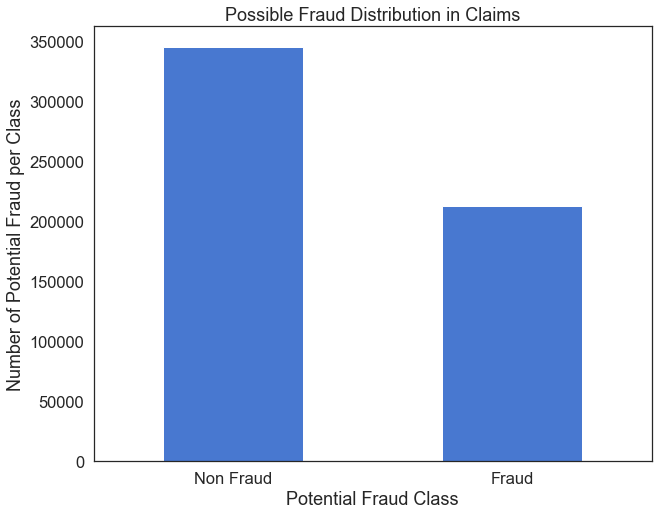

In [39]:
#i want to look at the frequency of fraud and non fraud claims within the dataset

sns.set_style('white', rc={'figure.figsize': (10, 8)})
count_classes = pd.value_counts(train_all_data['PotentialFraud'], sort=True)
print('Percentage Distribution of Potential Fraud Class:- \n', count_classes*100/len(train_all_data))
Labels = ['Non Fraud', 'Fraud']

#the bar plot
count_classes.plot(kind='bar', rot=0, figsize=(10,8))

plt.title("Possible Fraud Distribution in Claims")
plt.xticks(range(2), Labels)
plt.xlabel("Potential Fraud Class")
plt.ylabel("Number of Potential Fraud per Class")

plt.savefig('PotentialFraudDistribution')

There is a high amount of potential fraud